The visualizations on the datasets:
1. Emission trend graphs for each emission element
2. Production trend graphs for each production item/forest product
3. Distribution of forestry products
4. Distribution of production crops
5. Distribution of emissions and emission types

In [1]:
import io
import boto3
import pandas as pd

def read_datasets():
    # Read three datasets stored in the Amazon S3 bucket
   # bucket = "faostat-ml"
    file_name = "Emissions_Totals_E_All_Data_(Normalized).csv"
    #s3_client = boto3.client("s3")
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_emission = pd.read_csv("Emissions_Totals_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_emission.drop(df_emission.columns[df_emission.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

    #fix the feature names
    df_emission = df_emission.rename(columns={'Item': 'EmissionItem','Value': 'EmissionValue','Element': 'EmissionElement','Unit': 'EmissionUnit'})
    print(df_emission.head(5))

    file_name = "Production_Crops_Livestock_E_All_Data_(Normalized).csv"
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_prod = pd.read_csv("Production_Crops_Livestock_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_prod.drop(df_prod.columns[df_prod.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_prod.drop('Unit', axis=1, inplace=True)
    print(df_prod.head(5))


    file_name = "Forestry_E_All_Data_(Normalized).csv"
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_forest = pd.read_csv("Forestry_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_forest.drop(df_forest.columns[df_forest.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    print(df_forest.head(5))
    return df_emission, df_prod, df_forest

In [2]:
def pre_processing():
    remove_rows_df = pre_process_df.copy()
    
    # Removes area, source and emission unit that place no significant role
    remove_rows_df.drop('Area', axis=1, inplace=True)
    remove_rows_df.drop('Source', axis=1, inplace=True)
    remove_rows_df.drop('EmissionUnit', axis=1, inplace=True)
    
    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Area harvested"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Production"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Producing Animals/Slaughtered"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Indirect emissions (N2O)"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Direct emissions (N2O)"]
    remove_rows_df.index = remove_rows_df.Year
    remove_rows_df.drop('Year', axis=1, inplace=True)

    #identify partial string to look for
    discard = ['from']
    remove_rows_df = remove_rows_df[~remove_rows_df.EmissionElement.str.contains('|'.join(discard))]

    # Combine two features
    remove_rows_df["Emission"] = remove_rows_df["EmissionItem"] + str("_") + remove_rows_df["EmissionElement"]
    remove_rows_df.drop('EmissionItem', axis=1, inplace=True)
    remove_rows_df.drop('EmissionElement', axis=1, inplace=True)

    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Import Value']
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Export Value']
    
    emission_list = list(pre_process_df.EmissionItem.unique())

    # Create pivot table for production items + forestry products based on year and item
    df_item = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Item'], values='Value')
    
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_item.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_item.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_item.columns if df_item[i].isnull().any()]

    # Create pivot table for emissions
    df_emi = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Emission'], values='EmissionValue')
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_emi.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_emi.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_emi.columns if df_emi[i].isnull().any()]
    
    display(df_item.head(5))
    display(df_emi.head(5))
    return df_item, df_emi, emission_list

In [3]:
def plot_emissions():
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df_emi[df_emi.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df_emi.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();

In [4]:
def plot_productionitems():
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=4, ncols=3, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df_item[df_item.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df_item.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();

In [5]:
def time_series_prediction():
    pre_process_df = pd.DataFrame()
    combined_df = pd.DataFrame()

    import numpy as np
    import seaborn as sb
    import ipywidgets as widgets
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    from sklearn.preprocessing import LabelEncoder
    from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

    def unique_sorted_values_plus_ALL(array):
        unique = array.unique().tolist()
        unique.sort()
        return unique
    output_area = widgets.Output()
    print("Area:")
    dropdown_area = widgets.Dropdown(options=unique_sorted_values_plus_ALL(df_prod.Area))
    def dropdown_area_eventhandler(change):
        output_area.clear_output()
        with output_area:
            if(change.new):
                country_df_prod = df_prod[df_prod.Area == change.new]
                country_df_forest = df_forest[df_forest.Area == change.new]
                country_df_emission = df_emission[df_emission.Area == change.new]

                prod_forest_df = pd.concat([country_df_prod, country_df_forest], ignore_index=True)
                global pre_process_df, combined_df
                pre_process_df = pd.merge(prod_forest_df, country_df_emission, on=['Year','Area'])
    dropdown_area.observe(dropdown_area_eventhandler, names='value')
    display(dropdown_area)

In [6]:
# Run the functions from this module onwards for time series prediction
df_emission, df_prod, df_forest = read_datasets()

C:\Users\windows\AppData\Local\Temp\ipykernel_9180\2451332558.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_emission = pd.read_csv("Emissions_Totals_E_All_Data_(Normalized).csv",encoding='latin-1')


   Area Code         Area  Item Code          EmissionItem  Element Code  \
0          2  Afghanistan       5058  Enteric Fermentation          7225   
1          2  Afghanistan       5058  Enteric Fermentation          7225   
2          2  Afghanistan       5058  Enteric Fermentation          7225   
3          2  Afghanistan       5058  Enteric Fermentation          7225   
4          2  Afghanistan       5058  Enteric Fermentation          7225   

   EmissionElement  Year Code  Year  Source Code      Source EmissionUnit  \
0  Emissions (CH4)       1961  1961         3050  FAO TIER 1   kilotonnes   
1  Emissions (CH4)       1962  1962         3050  FAO TIER 1   kilotonnes   
2  Emissions (CH4)       1963  1963         3050  FAO TIER 1   kilotonnes   
3  Emissions (CH4)       1964  1964         3050  FAO TIER 1   kilotonnes   
4  Emissions (CH4)       1965  1965         3050  FAO TIER 1   kilotonnes   

   EmissionValue Flag Note  
0       240.6831   Fc  NaN  
1       245.3106   Fc 

In [7]:
time_series_prediction()

Area:


Dropdown(options=('Afghanistan', 'Africa', 'Albania', 'Algeria', 'Americas', 'Angola', 'Antigua and Barbuda', …

In [9]:
df_item, df_emi, emission_list = pre_processing()

C:\Users\windows\AppData\Local\Temp\ipykernel_9180\3410723638.py:39: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for items in sum.iteritems():
C:\Users\windows\AppData\Local\Temp\ipykernel_9180\3410723638.py:49: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for items in sum.iteritems():


Item,Asses,Barley,"Beans, dry",Beef and Buffalo Meat,Beehives,Buffaloes,Cattle,Cattle and Buffaloes,"Cereals, Total",Chickens,...,"Skins, goat, fresh","Skins, sheep, fresh",Sugar Crops Primary,Sugar beet,Sunflower seed,"Tobacco, unmanufactured",Tomatoes,Vegetables Primary,Vetches,Wheat
Year,,,,,,,,,,,,,,,,,,,,,
1961,57100.0,10224.0,7059.0,822.0,95100.0,6600.0,420200.0,426800.0,8452.0,1580.0,...,20.0,25.0,146531.0,146531.0,10000.0,2799.0,120000.0,120952.0,3240.0,7731.0
1962,58400.0,8405.0,7031.0,813.0,92800.0,5600.0,414900.0,420500.0,9418.0,1677.0,...,20.0,25.0,146489.0,146489.0,10000.0,4619.0,120000.0,117391.0,3688.0,10522.0
1963,59500.0,8770.0,7008.0,826.0,83500.0,5300.0,407100.0,412400.0,9823.0,1651.0,...,20.0,25.0,156977.0,156977.0,10510.0,6242.0,124000.0,120000.0,4001.0,7127.0
1964,57900.0,10258.0,6989.0,811.0,96500.0,4800.0,401500.0,406300.0,10233.0,1692.0,...,20.0,25.0,238413.0,238413.0,10339.0,5555.0,128000.0,120000.0,3766.0,9625.0
1965,59700.0,9865.0,6966.0,825.0,109800.0,4700.0,427100.0,431800.0,10373.0,1671.0,...,20.0,25.0,156751.0,156751.0,9142.0,5896.0,128000.0,121182.0,2857.0,11344.0


Emission,Agricultural Soils_Emissions (CO2eq) (AR5),Agricultural Soils_Emissions (N2O),Burning - Crop residues_Emissions (CH4),Burning - Crop residues_Emissions (CO2eq) (AR5),Burning - Crop residues_Emissions (N2O),Crop Residues_Emissions (CO2eq) (AR5),Crop Residues_Emissions (N2O),Enteric Fermentation_Emissions (CH4),Enteric Fermentation_Emissions (CO2eq) (AR5),IPCC Agriculture_Emissions (CH4),...,IPCC Agriculture_Emissions (N2O),Manure Management_Emissions (CH4),Manure Management_Emissions (CO2eq) (AR5),Manure Management_Emissions (N2O),Manure applied to Soils_Emissions (CO2eq) (AR5),Manure applied to Soils_Emissions (N2O),Manure left on Pasture_Emissions (CO2eq) (AR5),Manure left on Pasture_Emissions (N2O),Synthetic Fertilizers_Emissions (CO2eq) (AR5),Synthetic Fertilizers_Emissions (N2O)
Year,,,,,,,,,,,,,,,,,,,,,
1961,483.3130,1.8238,0.5771,20.1244,0.0150,23.3970,0.0883,51.0367,1429.0276,59.0109,...,2.1439,6.5663,264.7125,0.3051,119.1831,0.4497,323.1481,1.2194,17.5848,0.0664
1962,484.8759,1.8297,0.5209,18.1629,0.0135,24.6669,0.0931,51.4905,1441.7354,59.5791,...,2.1491,6.6135,266.2403,0.3059,119.7497,0.4519,329.4240,1.2431,11.0354,0.0416
1963,476.1283,1.7967,0.5344,18.6352,0.0139,21.6195,0.0816,51.2042,1433.7176,59.3533,...,2.1151,6.5308,263.5570,0.3045,118.4419,0.4470,325.0315,1.2265,11.0354,0.0416
1964,481.7031,1.8177,0.5374,18.7380,0.0139,26.4978,0.1000,51.4577,1440.8142,59.6664,...,2.1399,6.6805,268.7220,0.3082,119.4276,0.4507,324.7423,1.2254,11.0354,0.0416
1965,510.1155,1.9250,0.5454,19.0193,0.0141,24.8234,0.0937,54.9678,1539.0984,63.9776,...,2.2713,7.3631,294.1920,0.3322,128.7313,0.4858,345.5256,1.3039,11.0354,0.0416


Visualization - 1

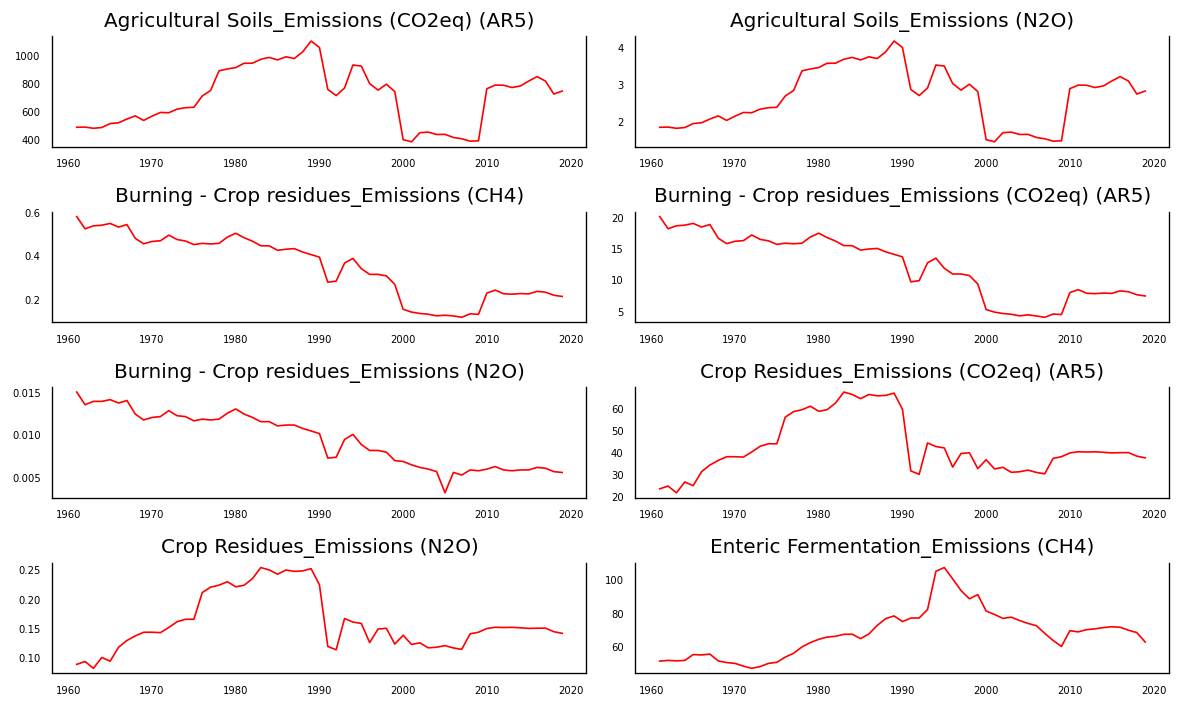

In [10]:
plot_emissions()

Visualization - 2

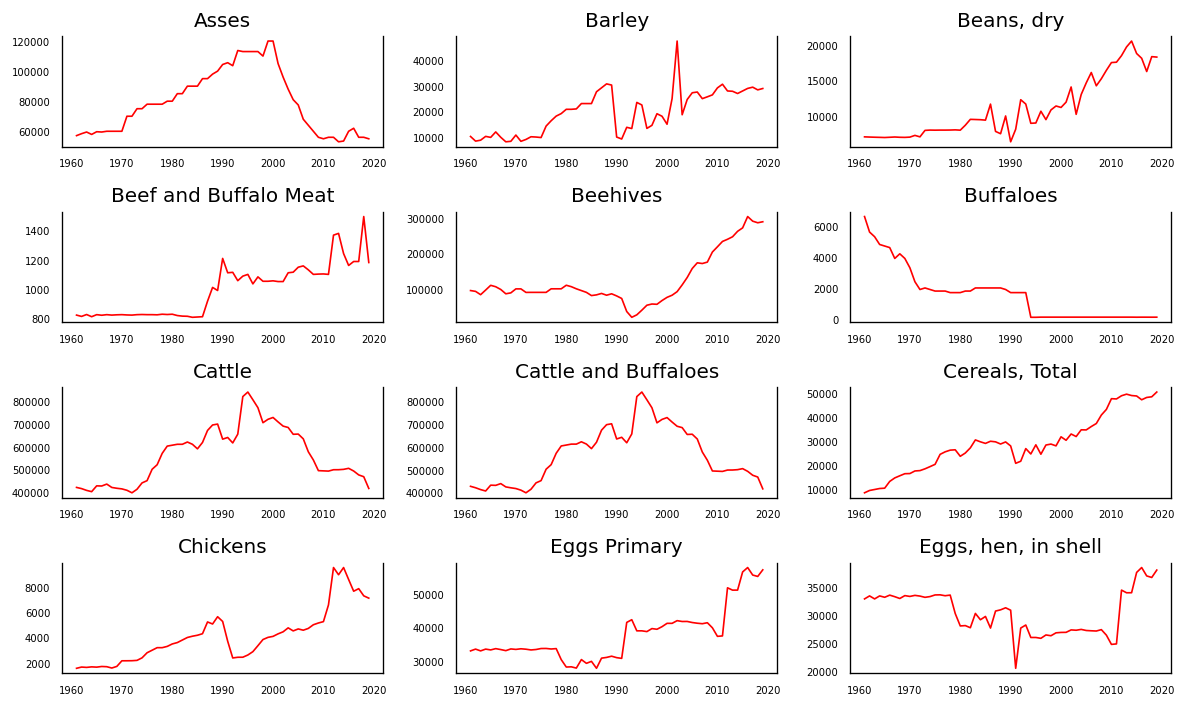

In [11]:
plot_productionitems()

Visualization - 3

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1964,1964,1000 US$,301.0,Im
1,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1965,1965,1000 US$,321.0,Im
2,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1966,1966,1000 US$,435.0,Im
3,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1967,1967,1000 US$,466.0,Im
4,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1968,1968,1000 US$,297.0,Im


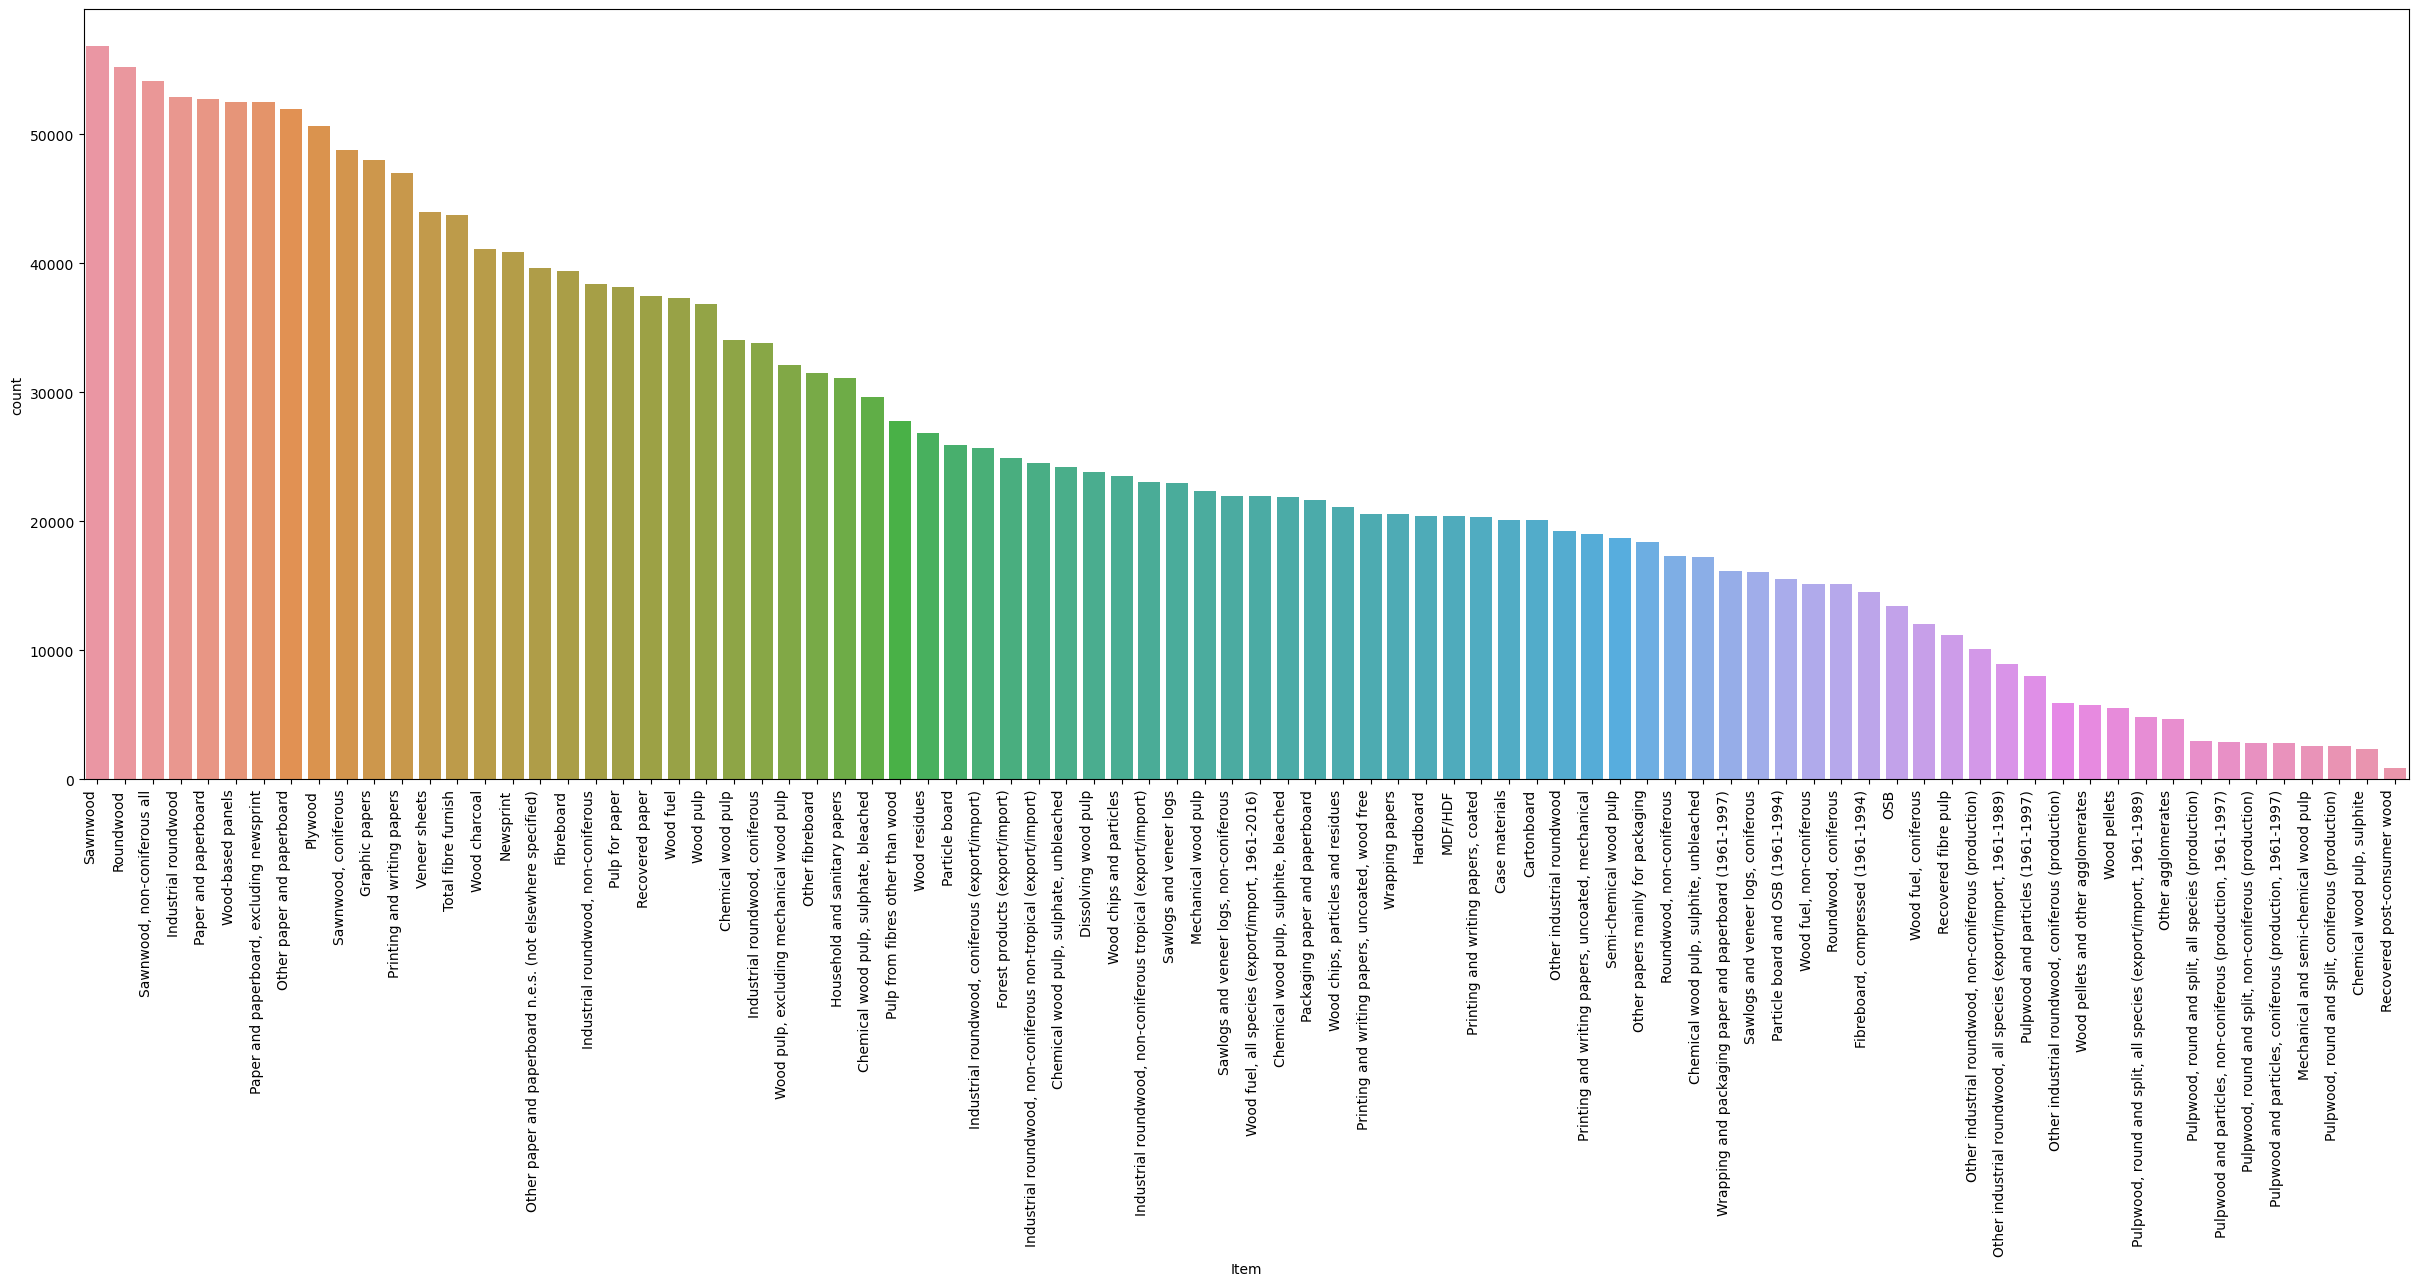

In [12]:
import matplotlib.pyplot as plt

display(df_forest.head(5))
import seaborn as sns
plt.figure(figsize = (30,10))
plot = sns.countplot(x='Item',data=df_forest, order = df_forest['Item'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

Visualization - 4

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,6000.0,F


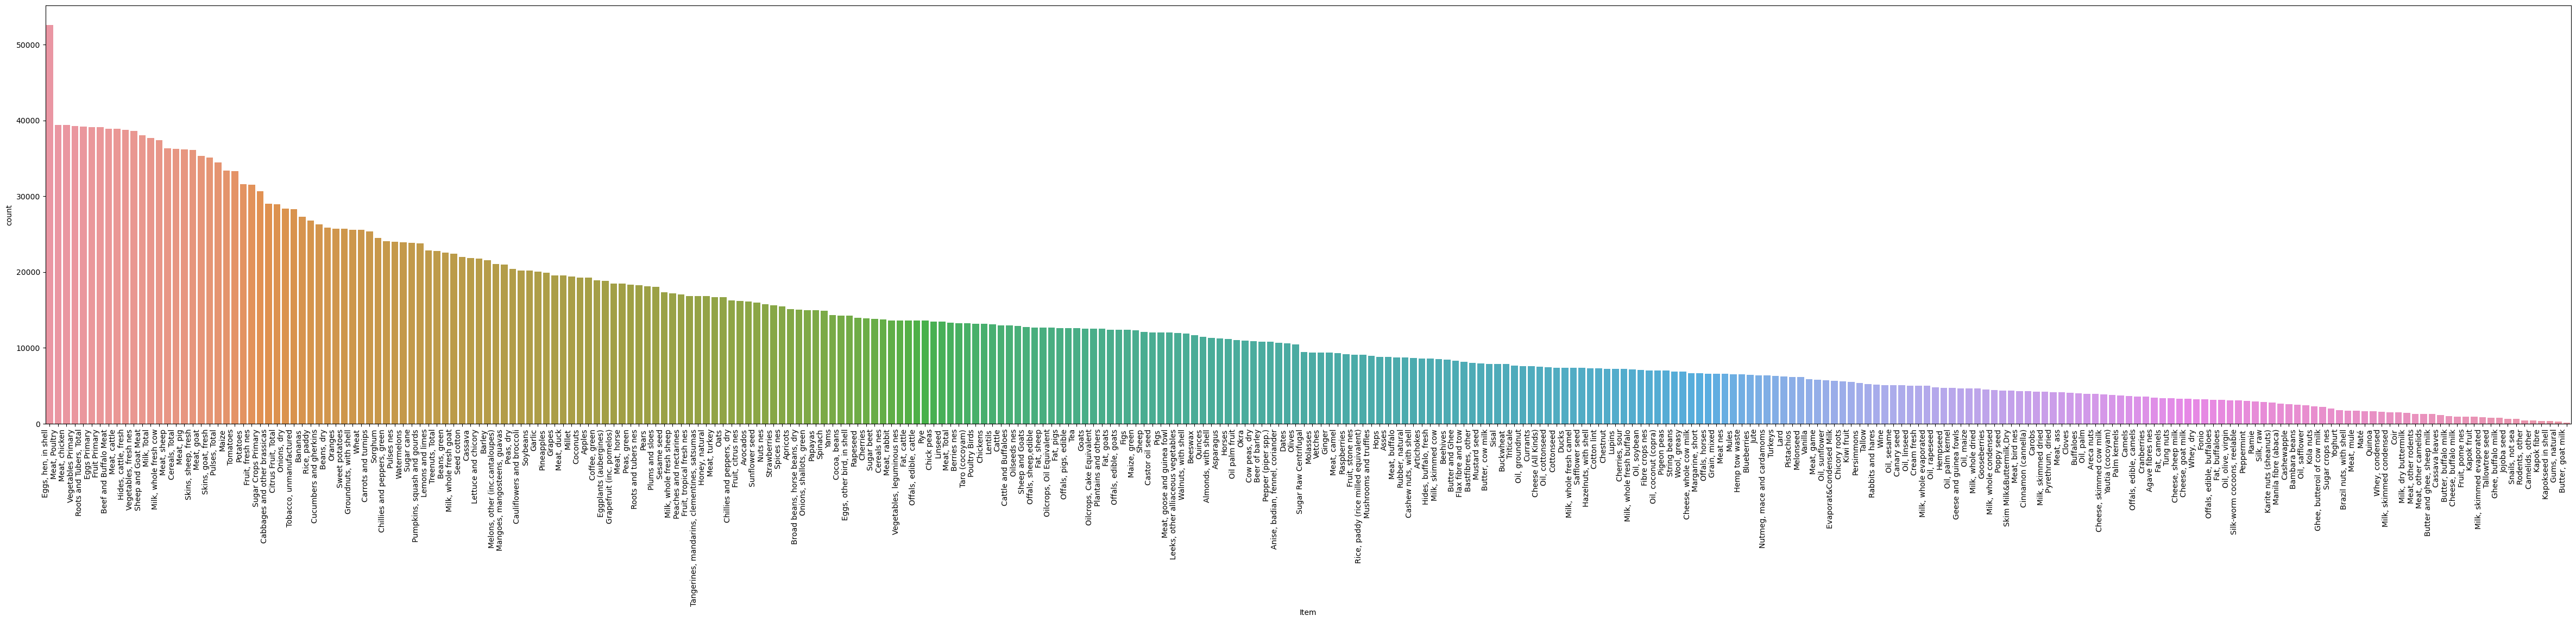

In [13]:
display(df_prod.head(5))

import seaborn as sns
plt.figure(figsize = (60,10))
plot = sns.countplot(x='Item',data=df_prod, order = df_prod['Item'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

Visualization - 5

,Area Code,Area,Item Code,EmissionItem,Element Code,EmissionElement,Year Code,Year,Source Code,Source,EmissionUnit,EmissionValue,Flag,Note
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1961,1961,3050,FAO TIER 1,kilotonnes,240.6831,Fc,NaN
1,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1962,1962,3050,FAO TIER 1,kilotonnes,245.3106,Fc,NaN
2,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1963,1963,3050,FAO TIER 1,kilotonnes,255.8285,Fc,NaN
3,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1964,1964,3050,FAO TIER 1,kilotonnes,259.0650,Fc,NaN
4,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1965,1965,3050,FAO TIER 1,kilotonnes,265.5980,Fc,NaN


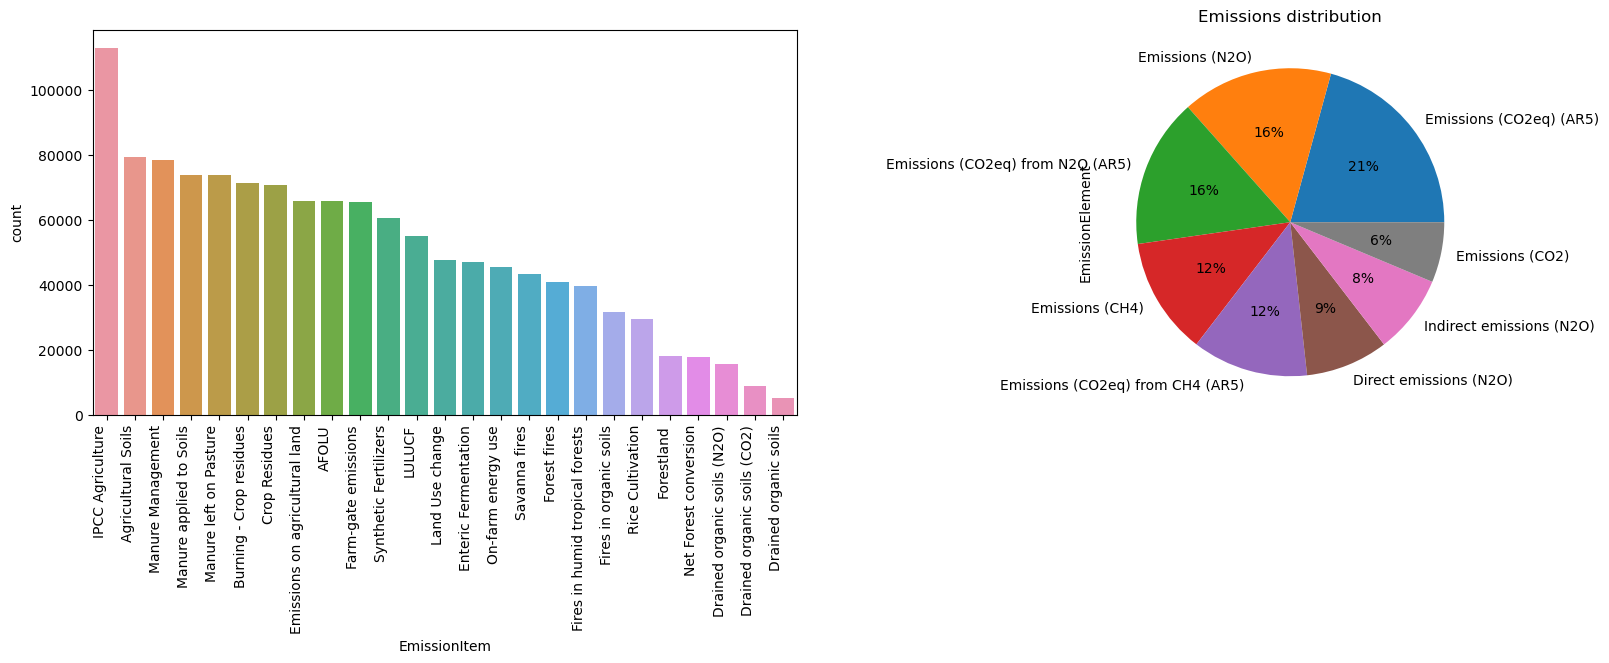

In [14]:
display(df_emission.head(5))

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
plot = sns.countplot(x='EmissionItem',data=df_emission, order = df_emission['EmissionItem'].value_counts().index, ax = ax1)
df_emission['EmissionElement'].value_counts().plot.pie(autopct='%1.0f%%', ax = ax2).set_title('Emissions distribution')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()